# MLP
Convert CNN_264 to an MLP.

More neurons.

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-27 19:46:20.305450


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 19:46:21.836332
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                16512     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,897
Trainable params: 24,897
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 19:46:22.238496
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 19:46:38.589830

Training # 1 1
2023-03-27 19:46:38.589986
2023-03-27 19:46:38.590034
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 19:46:38.653775


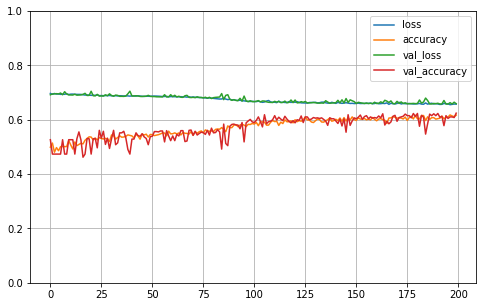


2023-03-27 19:49:01.899297

Testing # 1 1
2023-03-27 19:49:01.901102
2023-03-27 19:49:01.901452
PREDICT
2023-03-27 19:49:01.911192
Test 1:0 458:412 52.64%
Predict 1:0 459:411 52.76%
Test sizes (870, 257) (870,)
Range of scores: 0.042639315 to 0.8623109
Score threshold 0.5
Confusion matrix
 [[248 164]
 [163 295]]
Normalized matrix
 [[0.28505747 0.18850575]
 [0.18735632 0.33908046]]


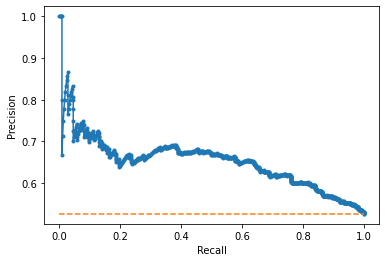

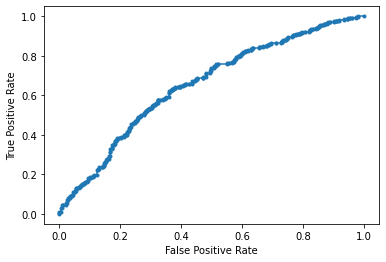

Accuracy: 62.41% Precision: 64.27% Recall: 64.41%
F1: 64.34% MCC: 0.2461
AUPRC: 65.26% AUROC: 65.46%
 accuracy [62.41379310344828]
 precision [64.27015250544662]
 recall [64.41048034934498]
 F1 [64.340239912759]
 MCC [0.24607719916859974]
 AUPRC [65.25770510776007]
 AUROC [65.4581973120787]
2023-03-27 19:49:02.746126

Training # 1 2
2023-03-27 19:49:02.746700
2023-03-27 19:49:02.746747
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 19:49:02.805911


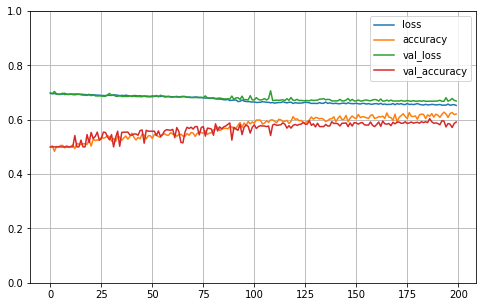


2023-03-27 19:51:25.731559

Testing # 1 2
2023-03-27 19:51:25.731644
2023-03-27 19:51:25.731694
PREDICT
2023-03-27 19:51:25.738939
Test 1:0 442:442 50.00%
Predict 1:0 591:293 66.86%
Test sizes (884, 257) (884,)
Range of scores: 0.065329306 to 0.9234432
Score threshold 0.5
Confusion matrix
 [[187 255]
 [106 336]]
Normalized matrix
 [[0.21153846 0.28846154]
 [0.1199095  0.3800905 ]]


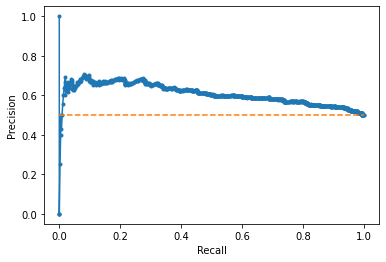

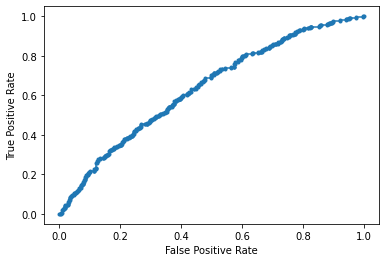

Accuracy: 59.16% Precision: 56.85% Recall: 76.02%
F1: 65.05% MCC: 0.1947
AUPRC: 60.65% AUROC: 63.69%
 accuracy [59.16289592760181]
 precision [56.852791878172596]
 recall [76.01809954751131]
 F1 [65.05324298160697]
 MCC [0.1946513715839701]
 AUPRC [60.64614403342282]
 AUROC [63.68624721033558]
2023-03-27 19:51:26.276984

Training # 1 3
2023-03-27 19:51:26.277244
2023-03-27 19:51:26.277327
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 19:51:26.341596


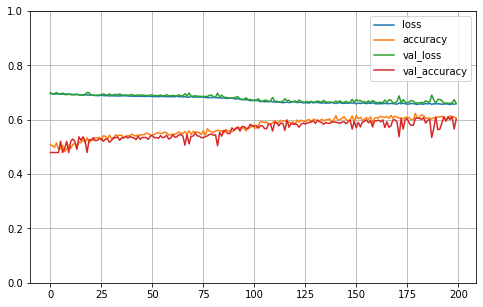


2023-03-27 19:52:49.157406

Testing # 1 3
2023-03-27 19:52:49.157516
2023-03-27 19:52:49.157554
PREDICT
2023-03-27 19:52:49.174422
Test 1:0 442:407 52.06%
Predict 1:0 602:247 70.91%
Test sizes (849, 257) (849,)
Range of scores: 0.079657234 to 0.893375
Score threshold 0.5
Confusion matrix
 [[158 249]
 [ 89 353]]
Normalized matrix
 [[0.1861013  0.29328622]
 [0.10482921 0.41578327]]


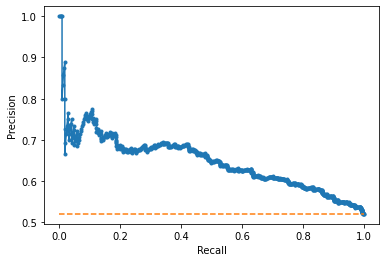

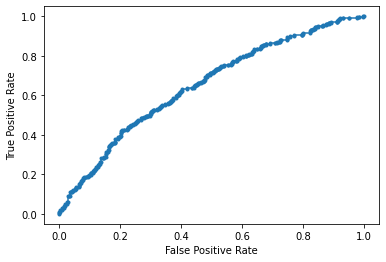

Accuracy: 60.19% Precision: 58.64% Recall: 79.86%
F1: 67.62% MCC: 0.2055
AUPRC: 64.85% AUROC: 64.94%
 accuracy [60.18845700824499]
 precision [58.63787375415283]
 recall [79.86425339366517]
 F1 [67.62452107279692]
 MCC [0.20551911160818268]
 AUPRC [64.85473039888883]
 AUROC [64.9438002379179]
2023-03-27 19:52:49.700466

Training # 1 4
2023-03-27 19:52:49.700600
2023-03-27 19:52:49.700641
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 19:52:49.777409


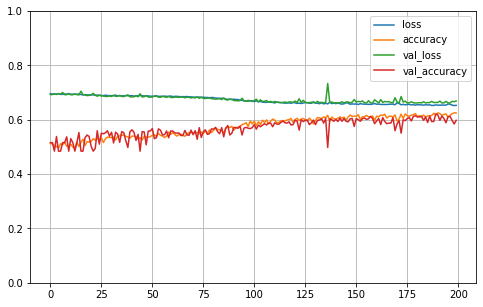


2023-03-27 19:55:12.657426

Testing # 1 4
2023-03-27 19:55:12.657520
2023-03-27 19:55:12.657560
PREDICT
2023-03-27 19:55:12.673164
Test 1:0 459:431 51.57%
Predict 1:0 305:585 34.27%
Test sizes (890, 257) (890,)
Range of scores: 0.034424014 to 0.883188
Score threshold 0.5
Confusion matrix
 [[329 102]
 [256 203]]
Normalized matrix
 [[0.36966292 0.11460674]
 [0.28764045 0.22808989]]


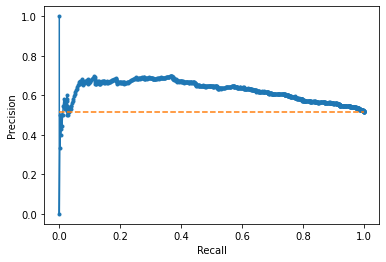

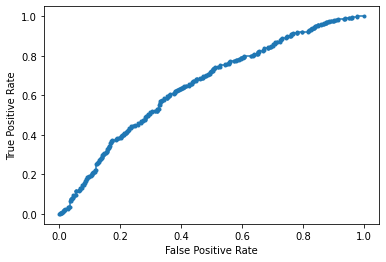

Accuracy: 59.78% Precision: 66.56% Recall: 44.23%
F1: 53.14% MCC: 0.2165
AUPRC: 62.51% AUROC: 65.07%
 accuracy [59.7752808988764]
 precision [66.55737704918033]
 recall [44.226579520697165]
 F1 [53.141361256544506]
 MCC [0.2164984199075895]
 AUPRC [62.51265551209073]
 AUROC [65.06578914112693]
2023-03-27 19:55:13.459050

Training # 1 5
2023-03-27 19:55:13.460521
2023-03-27 19:55:13.460846
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 19:55:13.548980


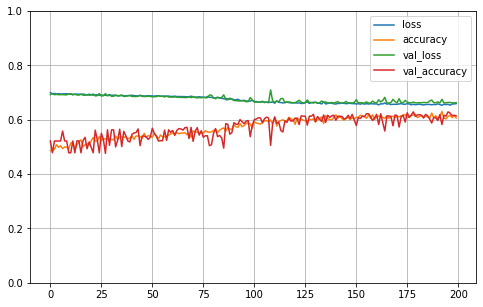


2023-03-27 19:57:37.385126

Testing # 1 5
2023-03-27 19:57:37.385211
2023-03-27 19:57:37.385244
PREDICT
2023-03-27 19:57:37.394320
Test 1:0 457:419 52.17%
Predict 1:0 491:385 56.05%
Test sizes (876, 257) (876,)
Range of scores: 0.034941874 to 0.9282383
Score threshold 0.5
Confusion matrix
 [[233 186]
 [152 305]]
Normalized matrix
 [[0.26598174 0.21232877]
 [0.17351598 0.34817352]]


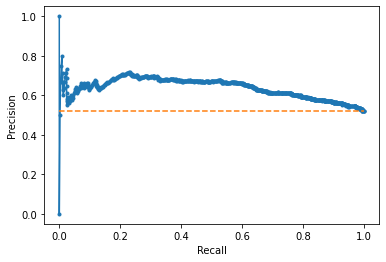

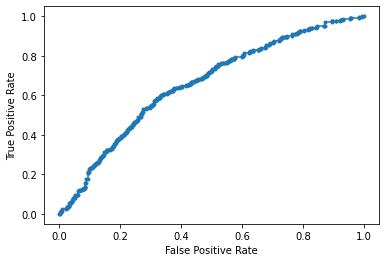

Accuracy: 61.42% Precision: 62.12% Recall: 66.74%
F1: 64.35% MCC: 0.2249
AUPRC: 63.77% AUROC: 65.74%
 accuracy [61.41552511415526]
 precision [62.11812627291242]
 recall [66.73960612691467]
 F1 [64.34599156118142]
 MCC [0.2249243693160563]
 AUPRC [63.76666915229416]
 AUROC [65.74317302319265]
2023-03-27 19:57:37.913578

Training # 2 1
2023-03-27 19:57:37.913743
2023-03-27 19:57:37.913794
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 19:57:37.977092


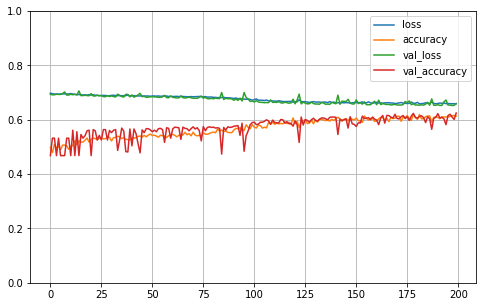


2023-03-27 19:59:05.317427

Testing # 2 1
2023-03-27 19:59:05.317492
2023-03-27 19:59:05.317520
PREDICT
2023-03-27 19:59:05.323326
Test 1:0 472:415 53.21%
Predict 1:0 365:522 41.15%
Test sizes (887, 257) (887,)
Range of scores: 0.05644096 to 0.89205664
Score threshold 0.5
Confusion matrix
 [[302 113]
 [220 252]]
Normalized matrix
 [[0.34047351 0.12739572]
 [0.24802706 0.28410372]]


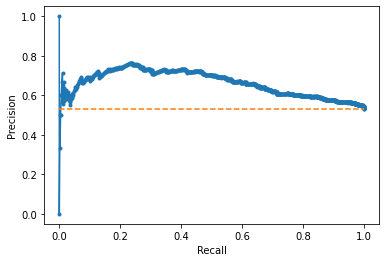

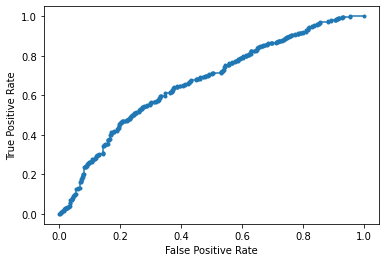

Accuracy: 62.46% Precision: 69.04% Recall: 53.39%
F1: 60.22% MCC: 0.2653
AUPRC: 66.13% AUROC: 66.78%
 accuracy [62.45772266065389]
 precision [69.04109589041096]
 recall [53.38983050847458]
 F1 [60.215053763440864]
 MCC [0.2652566564855016]
 AUPRC [66.12606486622272]
 AUROC [66.78068205023484]
2023-03-27 19:59:06.156592

Training # 2 2
2023-03-27 19:59:06.158239
2023-03-27 19:59:06.158612
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 19:59:06.258597


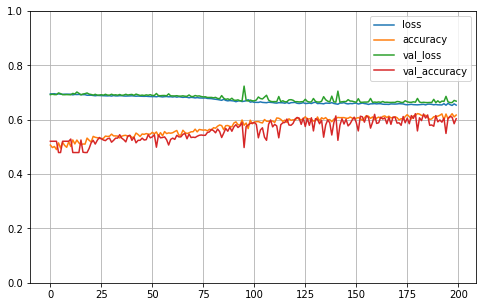


2023-03-27 20:01:29.551963

Testing # 2 2
2023-03-27 20:01:29.552068
2023-03-27 20:01:29.552104
PREDICT
2023-03-27 20:01:29.559698
Test 1:0 452:416 52.07%
Predict 1:0 326:542 37.56%
Test sizes (868, 257) (868,)
Range of scores: 0.04542203 to 0.8900564
Score threshold 0.5
Confusion matrix
 [[307 109]
 [235 217]]
Normalized matrix
 [[0.35368664 0.12557604]
 [0.27073733 0.25      ]]


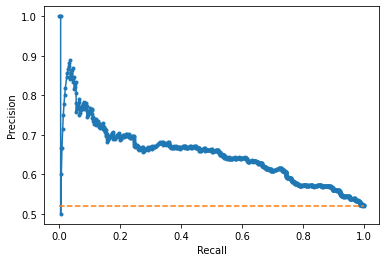

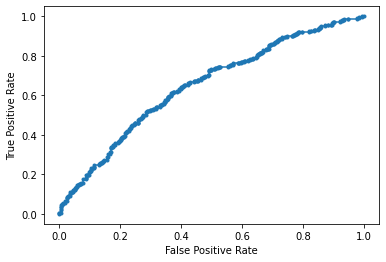

Accuracy: 60.37% Precision: 66.56% Recall: 48.01%
F1: 55.78% MCC: 0.2250
AUPRC: 65.15% AUROC: 64.88%
 accuracy [60.36866359447005]
 precision [66.56441717791411]
 recall [48.008849557522126]
 F1 [55.78406169665811]
 MCC [0.22495823650345076]
 AUPRC [65.14965105775235]
 AUROC [64.883636827774]
2023-03-27 20:01:30.085010

Training # 2 3
2023-03-27 20:01:30.085149
2023-03-27 20:01:30.085183
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 20:01:30.153964


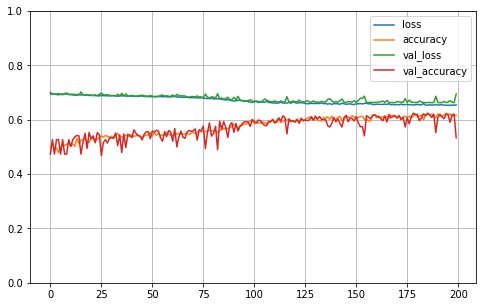


2023-03-27 20:02:58.417681

Testing # 2 3
2023-03-27 20:02:58.420602
2023-03-27 20:02:58.420999
PREDICT
2023-03-27 20:02:58.427229
Test 1:0 453:407 52.67%
Predict 1:0 156:704 18.14%
Test sizes (860, 257) (860,)
Range of scores: 0.017251974 to 0.8612748
Score threshold 0.5
Confusion matrix
 [[355  52]
 [349 104]]
Normalized matrix
 [[0.4127907  0.06046512]
 [0.40581395 0.12093023]]


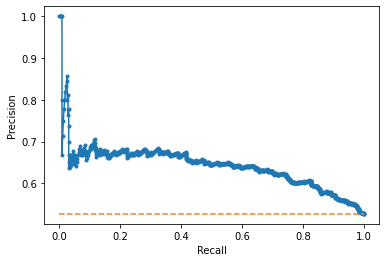

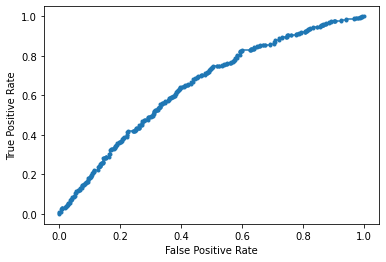

Accuracy: 53.37% Precision: 66.67% Recall: 22.96%
F1: 34.15% MCC: 0.1319
AUPRC: 64.32% AUROC: 64.97%
 accuracy [53.372093023255815]
 precision [66.66666666666666]
 recall [22.958057395143488]
 F1 [34.15435139573071]
 MCC [0.13192150923655657]
 AUPRC [64.3176478845008]
 AUROC [64.97496894847889]
2023-03-27 20:02:59.185953

Training # 2 4
2023-03-27 20:02:59.188214
2023-03-27 20:02:59.188630
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 20:02:59.278256


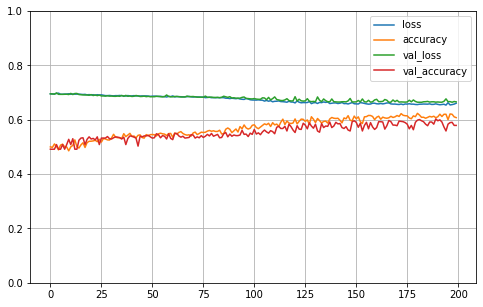


2023-03-27 20:04:26.883777

Testing # 2 4
2023-03-27 20:04:26.883881
2023-03-27 20:04:26.883916
PREDICT
2023-03-27 20:04:26.891315
Test 1:0 432:447 49.15%
Predict 1:0 578:301 65.76%
Test sizes (879, 257) (879,)
Range of scores: 0.03216039 to 0.8607799
Score threshold 0.5
Confusion matrix
 [[189 258]
 [112 320]]
Normalized matrix
 [[0.21501706 0.29351536]
 [0.12741752 0.36405006]]


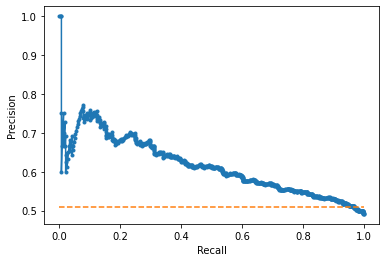

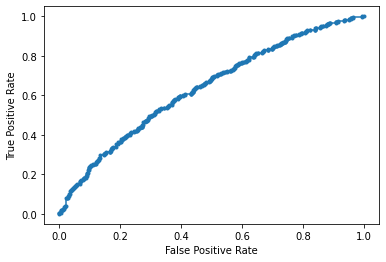

Accuracy: 57.91% Precision: 55.36% Recall: 74.07%
F1: 63.37% MCC: 0.1723
AUPRC: 61.59% AUROC: 63.65%
 accuracy [57.90671217292378]
 precision [55.36332179930796]
 recall [74.07407407407408]
 F1 [63.366336633663366]
 MCC [0.17231549383367453]
 AUPRC [61.58612375853985]
 AUROC [63.6543002734278]
2023-03-27 20:04:27.405872

Training # 2 5
2023-03-27 20:04:27.407167
2023-03-27 20:04:27.407215
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 20:04:27.470340


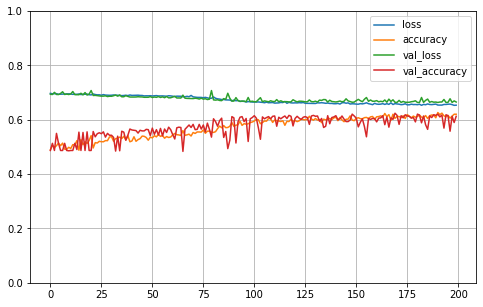


2023-03-27 20:06:50.526943

Testing # 2 5
2023-03-27 20:06:50.527046
2023-03-27 20:06:50.527084
PREDICT
2023-03-27 20:06:50.535969
Test 1:0 449:426 51.31%
Predict 1:0 398:477 45.49%
Test sizes (875, 257) (875,)
Range of scores: 0.035112653 to 0.92562836
Score threshold 0.5
Confusion matrix
 [[282 144]
 [195 254]]
Normalized matrix
 [[0.32228571 0.16457143]
 [0.22285714 0.29028571]]


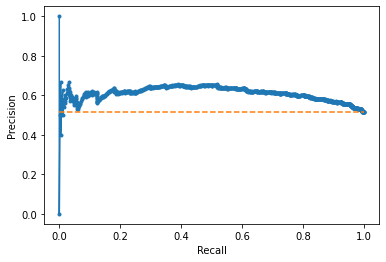

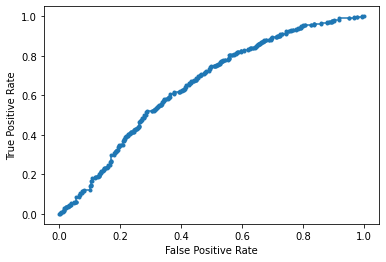

Accuracy: 61.26% Precision: 63.82% Recall: 56.57%
F1: 59.98% MCC: 0.2285
AUPRC: 60.96% AUROC: 65.14%
 accuracy [61.25714285714285]
 precision [63.81909547738693]
 recall [56.57015590200446]
 F1 [59.976387249114524]
 MCC [0.22852805250905217]
 AUPRC [60.96145509584454]
 AUROC [65.143197716365]
2023-03-27 20:06:51.318411


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.83% std 2.68
 precision mean 62.99% std 4.64
 recall mean 58.63% std 17.37
 F1 mean 58.80% std 9.73
 MCC mean 0.21% std 0.04
 AUPRC mean 63.52% std 1.96
 AUROC mean 65.03% std 0.91
 accuracy [[62.41379310344828], [59.16289592760181], [60.18845700824499], [59.7752808988764], [61.41552511415526], [62.45772266065389], [60.36866359447005], [53.372093023255815], [57.90671217292378], [61.25714285714285]]
 precision [[64.27015250544662], [56.852791878172596], [58.63787375415283], [66.55737704918033], [62.11812627291242], [69.04109589041096], [66.56441717791411], [66.66666666666666], [55.36332179930796], [63.81909547738693]]
 recall [[64.41048034934498], [76.01809954751131], [79.86425339366517], [44.226579520697165], [66.73960612691467], [53.38983050847458], [48.008849557522126], [22.958057395143488], [74.07407407407408], [56.57015590200446]]
 F1 [[64.340239912759], [65.05324298160697], [67.62452107279692], [53.141361256544506], [64.34599156118142], [60.215053763440864], [55.